In [1]:
# Importing the modules and libraries
# Additional libraries should be imported in this cell for organization

from datetime import datetime
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import pandas as pd
from pandas.plotting import autocorrelation_plot
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
import pmdarima as pm
from pmdarima.arima import ADFTest
from dateutil.relativedelta import relativedelta, MO
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(7)

# Purpose of This Test
The purpose of this code is to forecast multiple features ahead of time, then use the LSTM model's multiple feature forecasting method to forecast the desired data.

In [3]:
# Reading the dataset and creating the dataframes

dataset = pd.read_csv("Compiegne_HourlyGID_2022-2023.csv", skiprows=10, skipfooter=10)
df_Compiegne = pd.DataFrame(dataset)

print(df_Compiegne.head())

            time    P  G(i)  H_sun    T2m  WS10m  Int
0  20220101:0010  0.0   0.0    0.0  10.99   2.55  0.0
1  20220101:0110  0.0   0.0    0.0  11.01   2.41  0.0
2  20220101:0210  0.0   0.0    0.0  11.09   2.21  0.0
3  20220101:0310  0.0   0.0    0.0  11.05   2.14  0.0
4  20220101:0410  0.0   0.0    0.0  10.80   2.34  0.0


C:\Users\ugurhan\AppData\Local\Temp\ipykernel_13456\1472679268.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  dataset = pd.read_csv("Compiegne_HourlyGID_2022-2023.csv", skiprows=10, skipfooter=10)


# Explanations of the Variables
<b>P:</b> PV system power (W) <br>
<b>G(i):</b> Global irradiance on the inclined plane (plane of the array) (W/m2) <br>
<b>H_sun:</b> Sun height (degree) <br>
<b>T2m:</b> 2-m air temperature (degree Celsius) <br>
<b>WS10m:</b> 10-m total wind speed (m/s) <br>
<b>Int:</b> 1 means solar radiation values are reconstructed

In [4]:
df_Compiegne

,time,P,G(i),H_sun,T2m,WS10m,Int
0,20220101:0010,0.0,0.0,0.0,10.99,2.55,0.0
1,20220101:0110,0.0,0.0,0.0,11.01,2.41,0.0
2,20220101:0210,0.0,0.0,0.0,11.09,2.21,0.0
3,20220101:0310,0.0,0.0,0.0,11.05,2.14,0.0
4,20220101:0410,0.0,0.0,0.0,10.80,2.34,0.0
...,...,...,...,...,...,...,...
17515,20231231:1910,0.0,0.0,0.0,8.51,7.17,0.0
17516,20231231:2010,0.0,0.0,0.0,8.43,7.03,0.0
17517,20231231:2110,0.0,0.0,0.0,8.31,7.10,0.0
17518,20231231:2210,0.0,0.0,0.0,8.00,6.97,0.0


In [5]:
# Calculate the split index
split_index = int(len(df_Compiegne) * 0.80)

# Split the DataFrame
df_Compiegne_past = df_Compiegne[:split_index]
df_Compiegne_future = df_Compiegne[split_index:]

# Display the sizes of the splits
print(f"Training set size: {len(df_Compiegne_past)}")
print(f"Testing set size: {len(df_Compiegne_future)}")

Training set size: 14016
Testing set size: 3504


The time data can be separated into 'years' and 'hours', but both the LSTM model and the ARIMA model already take the data as a sequential sample, so the time data will be dropped during the training.

# Forecasting Natural & Time-Sensitive Data
The ARIMA model will be used to forecast future data that don't depend on other factors (i.e. global irradiance, sun height etc.)

## Global Irradiance

In [6]:
df_Compiegne_future_Gi = df_Compiegne_future.iloc[:, [2]]

print(df_Compiegne_future_Gi.head())

       G(i)
14016   0.0
14017   0.0
14018   0.0
14019   0.0
14020   0.0


   G(i)
0   0.0
1   0.0
2   0.0
3   0.0
4   0.0


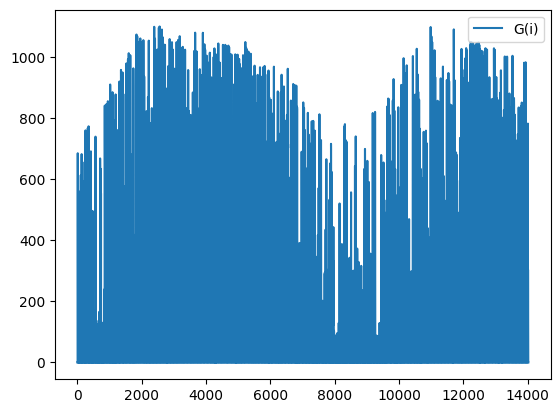

In [7]:
df_Compiegne_past_Gi = df_Compiegne_past.iloc[:, [2]]

print(df_Compiegne_past_Gi.head())

df_Compiegne_past_Gi.plot()
plt.show()

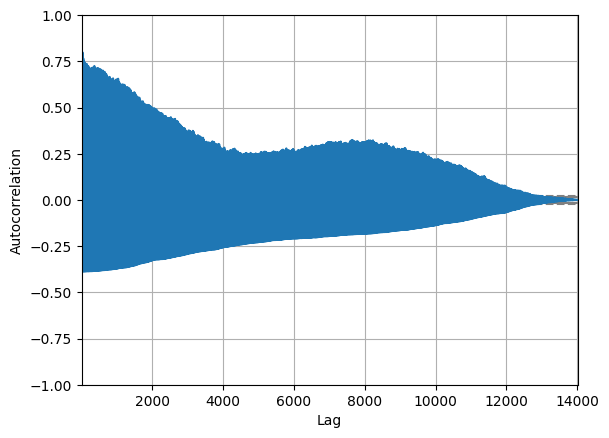

In [8]:
autocorrelation_plot(df_Compiegne_past_Gi)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                   G(i)   No. Observations:                14016
Model:                ARIMA(10, 1, 0)   Log Likelihood              -86530.950
Date:                Thu, 23 Jan 2025   AIC                         173083.900
Time:                        09:50:58   BIC                         173166.927
Sample:                             0   HQIC                        173111.539
                              - 14016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1248      0.005     26.271      0.000       0.116       0.134
ar.L2          0.1435      0.005     28.358      0.000       0.134       0.153
ar.L3          0.0389      0.006      6.981      0.0

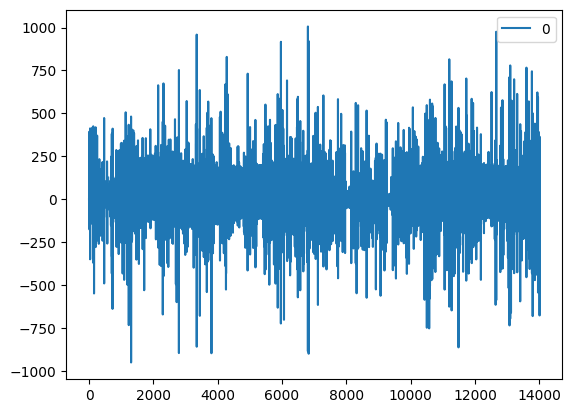

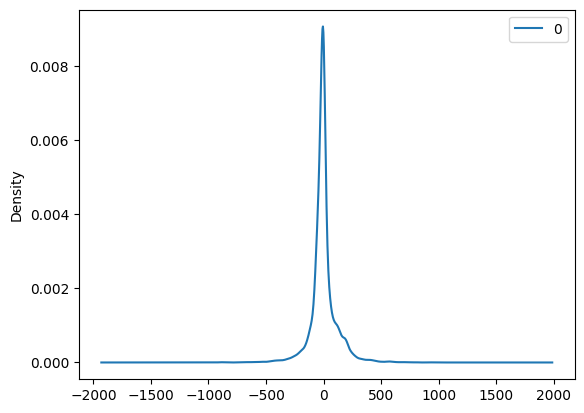

                  0
count  14016.000000
mean       0.006085
std      116.188534
min     -951.654911
25%      -39.246992
50%       -5.417905
75%       23.800887
max     1006.528492


In [9]:
# fit model
model_arima = ARIMA(df_Compiegne_past_Gi, order=(10,1,0))
model_fit = model_arima.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [10]:
# split into train and test sets
X = df_Compiegne_past_Gi.values
Y = df_Compiegne_future_Gi.values
train, test = X, Y

In [11]:
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(10,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	if (yhat < 0):
		predictions.append(0)
	else:
		predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
	
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_9084\2289066844.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f' % (yhat, obs))


predicted=28.066420, expected=0.000000
predicted=21.820190, expected=0.000000
predicted=17.906024, expected=0.000000
predicted=11.394541, expected=0.000000
predicted=5.167283, expected=0.000000
predicted=1.855471, expected=24.890000
predicted=27.997121, expected=102.370000
predicted=115.615128, expected=273.670000
predicted=307.155631, expected=513.330000
predicted=570.144960, expected=381.290000
predicted=401.776942, expected=450.640000
predicted=436.907863, expected=674.430000
predicted=679.182521, expected=590.410000
predicted=578.858738, expected=733.900000
predicted=712.059031, expected=573.660000
predicted=533.779126, expected=268.480000
predicted=175.111191, expected=194.440000
predicted=100.793360, expected=79.780000
predicted=20.738645, expected=19.740000
predicted=-8.818625, expected=0.000000
predicted=1.451089, expected=0.000000
predicted=29.935578, expected=0.000000
predicted=48.025640, expected=0.000000
predicted=47.676347, expected=0.000000
predicted=44.316818, expected=0

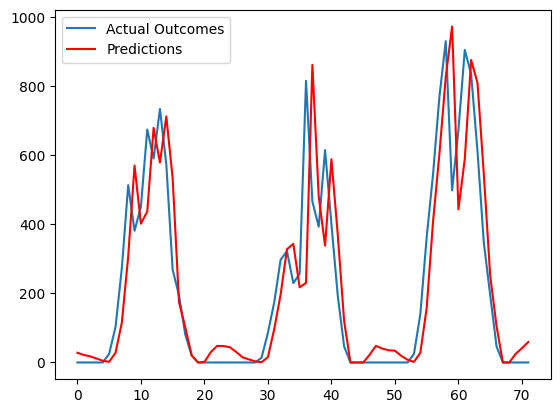

In [12]:
# plot forecasts against actual outcomes
plt.plot(test[:72], label='Actual Outcomes')
plt.plot(predictions[:72], color='red', label='Predictions')
plt.legend()
plt.show()

In [29]:
train[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
# Forecast future timesteps
future_predictions = []

# num_future_steps = len(df_Compiegne_future)  # Predict the next timesteps
num_future_steps = 72

future_history = [x for x in train[:,0]]

for _ in range(num_future_steps):

    future_model = ARIMA(future_history, order=(10, 1, 0))
    future_model_fit = future_model.fit()
    future_output = future_model_fit.forecast()

    # Get residuals from the ARIMA model on training data
    residuals = np.array(future_model_fit.resid)  # Residuals are the errors of predictions
    std_residuals = np.std(residuals)  # Calculate the standard deviation of residuals

    future_yhat = future_output[0] + np.random.normal(0, std_residuals)  # Add noise
    future_predictions.append(future_yhat)
    future_history.append(future_yhat) # Use predicted value as next input

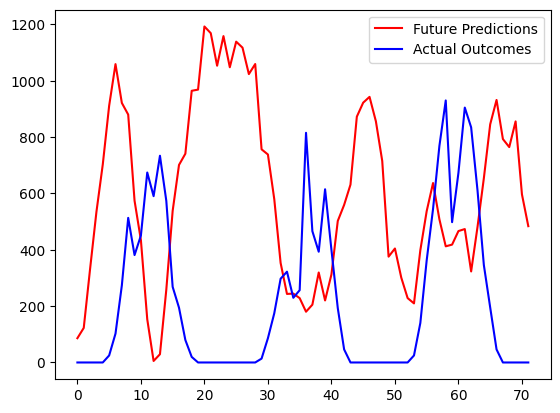

Future Predictions:
[np.float64(86.18038053629463), np.float64(122.68351167015273), np.float64(332.4585850146641), np.float64(535.0599317333885), np.float64(703.4943445489982), np.float64(911.3384988767223), np.float64(1059.1537765767227), np.float64(921.3616291744411), np.float64(880.059666175801), np.float64(574.347693006715), np.float64(434.2963654548535), np.float64(153.32991503241783), np.float64(5.373998915051434), np.float64(29.272762708521086), np.float64(258.4442487884323), np.float64(538.1395252841734), np.float64(701.3067655328161), np.float64(741.0899011060558), np.float64(964.51457011165), np.float64(968.6754741748922), np.float64(1192.8083521151332), np.float64(1169.0450633963703), np.float64(1053.4646288963208), np.float64(1158.6610016036932), np.float64(1048.04247801315), np.float64(1138.9121806344049), np.float64(1117.6915583419172), np.float64(1023.772354899993), np.float64(1059.5118233065884), np.float64(756.7101600367733), np.float64(738.3373466807338), np.float64(5

In [31]:
# Plot future predictions
plt.plot(future_predictions, color='red', label='Future Predictions')
plt.plot(test[:72], label='Actual Outcomes', color='blue')
plt.legend()
plt.show()

print("Future Predictions:")
print(future_predictions)

In [27]:
# Convert the array to a list of rounded values with two decimal places
rounded_predictions = [round(float(value), 2) for value in future_predictions]

# Create a new DataFrame and add the rounded values as a new column
df_Compiegne_predictions = pd.DataFrame({'G(i)': rounded_predictions})

# Display the DataFrame
print(df_Compiegne_predictions)

       G(i)
0      3.96
1      8.24
2     11.55
3     12.68
4     13.31
...     ...
3499   8.72
3500   8.72
3501   8.72
3502   8.72
3503   8.72

[3504 rows x 1 columns]


## Sun Height

In [47]:
df_Compiegne_future_Hsun = df_Compiegne_future.iloc[:, [3]]

print(df_Compiegne_future_Hsun.head())

       H_sun
14016    0.0
14017    0.0
14018    0.0
14019    0.0
14020    0.0


   H_sun
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0


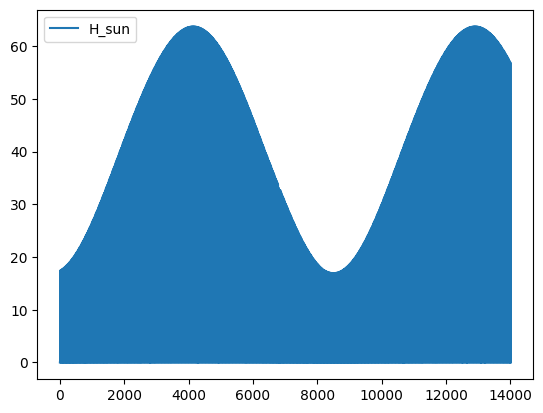

In [48]:
df_Compiegne_past_Hsun = df_Compiegne_past.iloc[:, [3]]

print(df_Compiegne_past_Hsun.head())

df_Compiegne_past_Hsun.plot()
plt.show()

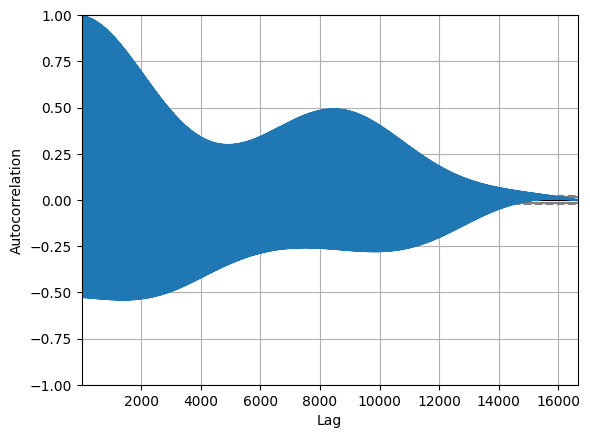

In [68]:
autocorrelation_plot(df_Compiegne_past_Hsun)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  H_sun   No. Observations:                16644
Model:                ARIMA(10, 1, 0)   Log Likelihood              -42835.124
Date:                Wed, 22 Jan 2025   AIC                          85692.249
Time:                        15:06:53   BIC                          85777.166
Sample:                             0   HQIC                         85720.280
                              - 16644                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6415      0.003    204.605      0.000       0.635       0.648
ar.L2          0.2555      0.004     72.289      0.000       0.249       0.262
ar.L3         -0.0572      0.004    -12.902      0.0

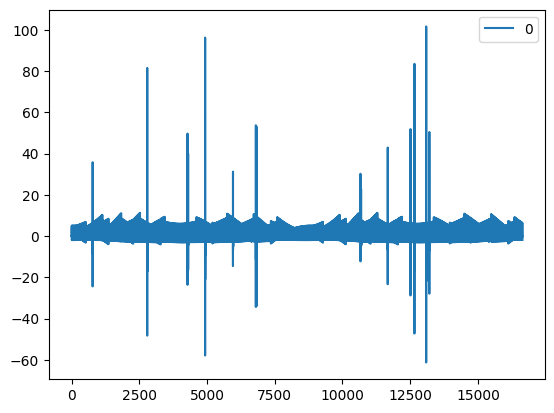

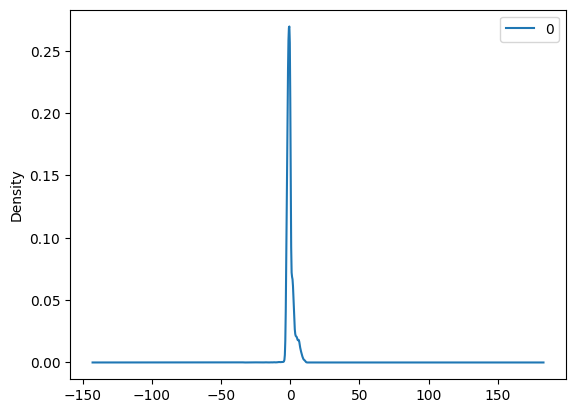

                  0
count  16644.000000
mean       0.000336
std        3.173311
min      -61.309576
25%       -1.475481
50%       -0.563563
75%        0.490097
max      101.609596


In [69]:
# fit model
model_arima = ARIMA(df_Compiegne_past_Hsun, order=(10,1,0))
model_fit = model_arima.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [70]:
# split into train and test sets
X = df_Compiegne_past_Hsun.values
Y = df_Compiegne_future_Hsun.values
train, test = X, Y
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(10,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
	
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_2876\1884660431.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f' % (yhat, obs))


predicted=21.217300, expected=19.440000
predicted=18.363889, expected=16.770000
predicted=13.224432, expected=11.910000
predicted=6.597962, expected=5.260000
predicted=-0.638698, expected=0.000000
predicted=-4.156634, expected=0.000000
predicted=-0.393763, expected=0.000000
predicted=1.362980, expected=0.000000
predicted=1.326195, expected=0.000000
predicted=0.871450, expected=0.000000
predicted=0.367672, expected=0.000000
predicted=-0.109121, expected=0.000000
predicted=-0.123633, expected=0.000000
predicted=0.454863, expected=0.000000
predicted=0.622473, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=6.200000
predicted=10.178024, expected=12.590000
predicted=18.273585, expected=17.140000
predicted=21.336077, expected=19.440000
predicted=21.044858, expected=19.250000
predicted=18.201057, expect

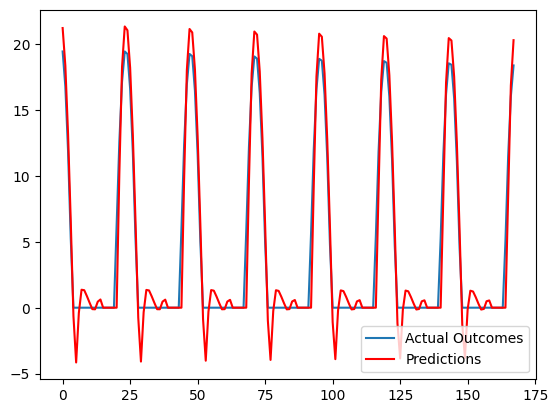

In [71]:
# plot forecasts against actual outcomes
plt.plot(test[:168], label='Actual Outcomes')
plt.plot(predictions[:168], color='red', label='Predictions')
plt.legend()
plt.show()

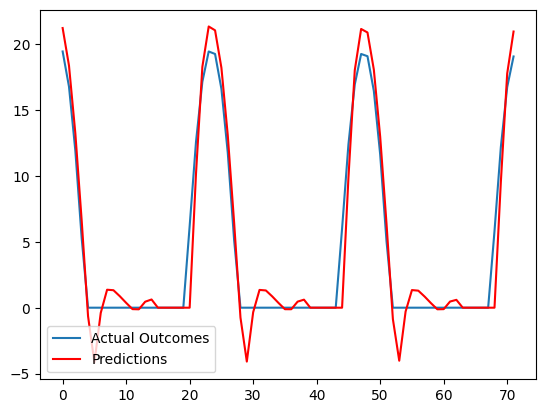

In [72]:
# plot forecasts against actual outcomes
plt.plot(test[:72], label='Actual Outcomes')
plt.plot(predictions[:72], color='red', label='Predictions')
plt.legend()
plt.show()

In [75]:
# Forecast future timesteps
future_predictions = []
# num_future_steps = len(df_Compiegne_future)  # Predict the next timesteps
num_future_steps = 168

future_history = [x for x in train[:,0]]

for _ in range(num_future_steps):
    future_model = ARIMA(future_history, order=(10, 1, 0))
    future_model_fit = future_model.fit()
    future_output = future_model_fit.forecast()
    future_yhat = future_output[0]
    future_predictions.append(future_yhat)
    future_history.append(future_yhat)  # Use predicted value as next input

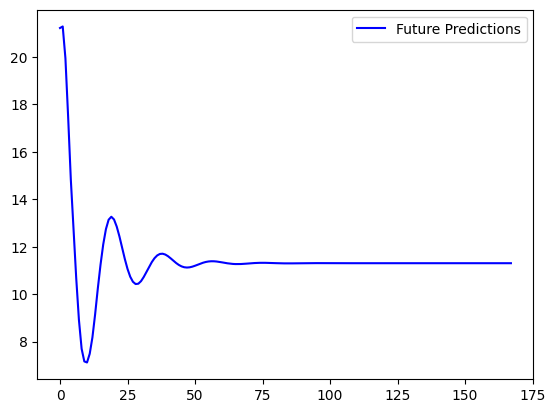

Future Predictions:
[np.float64(21.217300014031558), np.float64(21.28153215280275), np.float64(19.94418044245972), np.float64(17.488859523942303), np.float64(14.833642540291722), np.float64(12.761521815745244), np.float64(10.674415477632802), np.float64(8.921204112821314), np.float64(7.699544568622497), np.float64(7.1658959691658985), np.float64(7.121114860792171), np.float64(7.48837336771884), np.float64(8.177692691713274), np.float64(9.149294060178944), np.float64(10.242107783711809), np.float64(11.239549980348848), np.float64(12.094582541203012), np.float64(12.738741056928788), np.float64(13.136938993600667), np.float64(13.262347877755358), np.float64(13.147765493578833), np.float64(12.84903583395505), np.float64(12.435423014845336), np.float64(11.961191614664722), np.float64(11.483673215677053), np.float64(11.063530737434338), np.float64(10.736299835878818), np.float64(10.522795631005824), np.float64(10.426315644324019), np.float64(10.440715770144438), np.float64(10.548069472293342

In [76]:
# Plot future predictions
plt.plot(future_predictions, color='blue', label='Future Predictions')
plt.legend()
plt.show()

print("Future Predictions:")
print(future_predictions)

In [ ]:
# Convert the array to a list of rounded values with two decimal places
rounded_predictions = [round(float(value), 2) for value in future_predictions]

# Add the new column
df_Compiegne_predictions['H_sun'] = rounded_predictions

# Display the DataFrame
print(df_Compiegne_predictions)

# Other Methods

## SARIMAX Model

In [9]:
df_Compiegne['time'] = pd.to_datetime(df_Compiegne['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)
df_Compiegne = df_Compiegne.set_index(['time'])

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_13456\1384054282.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_Compiegne['time'] = pd.to_datetime(df_Compiegne['time'].str.replace(':', ''), format='%Y%m%d%H%M', infer_datetime_format=True)


In [10]:
df_Compiegne['H_sun_diff'] = df_Compiegne['H_sun'].diff(periods=730)
df_Compiegne.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2022-01-01 00:10:00 to 2023-12-31 23:10:00
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   P           17520 non-null  float64
 1   G(i)        17520 non-null  float64
 2   H_sun       17520 non-null  float64
 3   T2m         17520 non-null  float64
 4   WS10m       17520 non-null  float64
 5   Int         17520 non-null  float64
 6   H_sun_diff  16790 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


In [11]:
df_Compiegne['H_sun_diff'].fillna(method='backfill', inplace=True)

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_10124\2751644176.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_Compiegne['H_sun_diff'].fillna(method='backfill', inplace=True)
C:\Users\ugurhan\AppData\Local\Temp\ipykernel_10124\2751644176.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_Compiegne['H_sun_diff'].fillna(method='backfill', inplace=True)


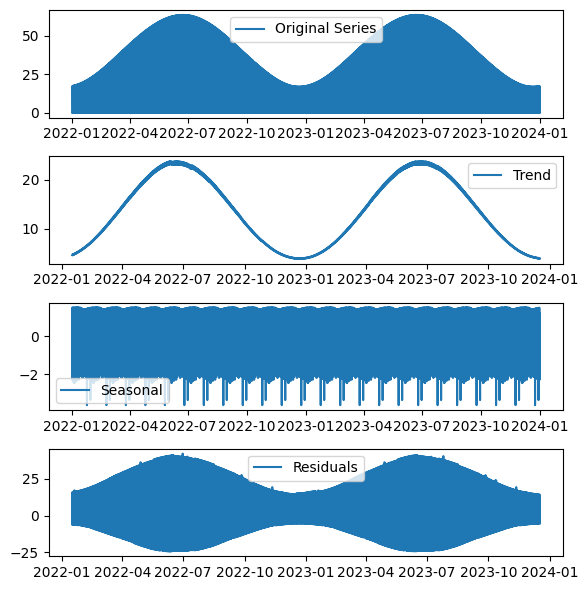

In [21]:
result = seasonal_decompose(df_Compiegne['H_sun'], model='additive', period=730)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(6,6))

plt.subplot(4, 1, 1)
plt.plot(df_Compiegne['H_sun'], label='Original Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
df_Compiegne['day_index'] = df_Compiegne.index.day

In [23]:
SARIMAX_model = pm.auto_arima(df_Compiegne[['H_sun']], exogenous=df_Compiegne[['day_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

In [24]:
def sarimax_forecast(SARIMAX_model, periods=730):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"day_index": pd.date_range(df_Compiegne.index[-1], periods=n_periods, freq='MS').day},
                               index=pd.date_range(df_Compiegne.index[-1] + pd.DateOffset(days=1), periods=n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[['day_index']])
    index_of_fc = pd.date_range(df_Compiegne.index[-1] + pd.DateOffset(days=1), periods=n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(df_Compiegne["H_sun"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                     lower_series,
                     upper_series,
                     color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Sun Height")
    plt.show()

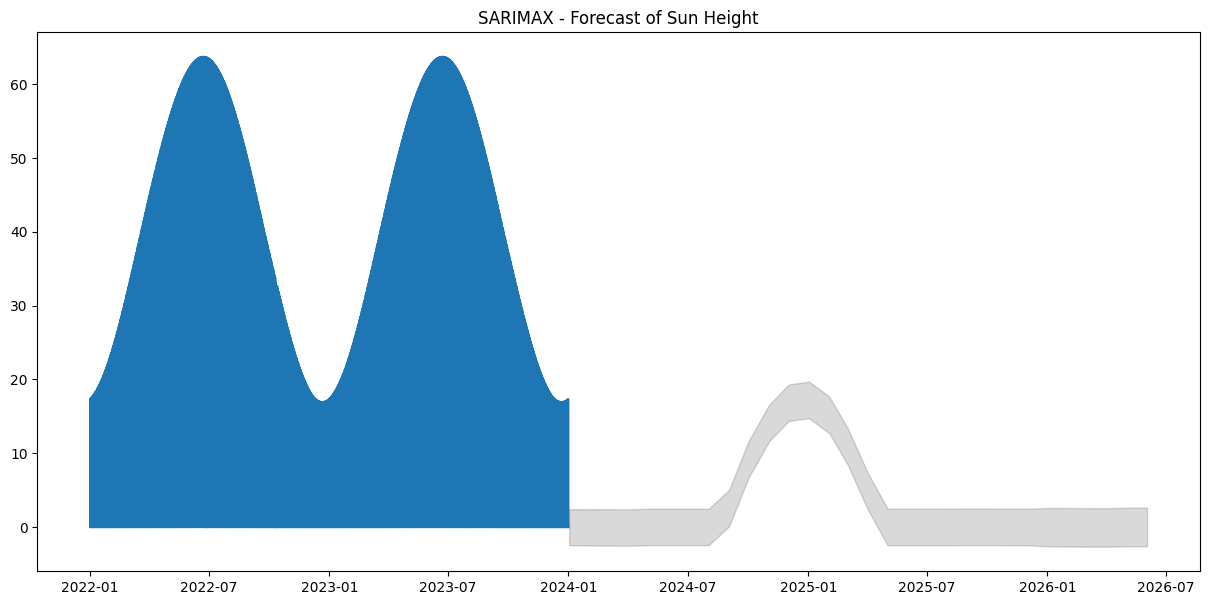

In [26]:
sarimax_forecast(SARIMAX_model, periods=30)

## Auto ARIMA (Hard Method, Will Get Back to it)

In [13]:
df_Compiegne = df_Compiegne.drop(['H_sun_diff'], axis=1)

df_Compiegne

,P,G(i),H_sun,T2m,WS10m,Int
time,,,,,,
2022-01-01 00:10:00,0.0,0.0,0.0,10.99,2.55,0.0
2022-01-01 01:10:00,0.0,0.0,0.0,11.01,2.41,0.0
2022-01-01 02:10:00,0.0,0.0,0.0,11.09,2.21,0.0
2022-01-01 03:10:00,0.0,0.0,0.0,11.05,2.14,0.0
2022-01-01 04:10:00,0.0,0.0,0.0,10.80,2.34,0.0
...,...,...,...,...,...,...
2023-12-31 19:10:00,0.0,0.0,0.0,8.51,7.17,0.0
2023-12-31 20:10:00,0.0,0.0,0.0,8.43,7.03,0.0
2023-12-31 21:10:00,0.0,0.0,0.0,8.31,7.10,0.0


In [14]:
# Generate a summary of the DataFrame's statistics, including datetime columns treated as numeric
display(df_Compiegne.describe(include='all'))

,P,G(i),H_sun,T2m,WS10m,Int
count,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.0
mean,131.500406,167.560503,13.266911,12.525989,3.388746,0.0
std,218.027178,273.036345,17.936955,7.091458,1.624037,0.0
min,0.000000,0.000000,0.000000,-5.040000,0.000000,0.0
25%,0.000000,0.000000,0.000000,7.540000,2.210000,0.0
50%,0.000000,0.000000,0.000000,12.020000,3.100000,0.0
75%,170.807500,221.532500,23.402500,17.582500,4.280000,0.0
max,906.820000,1099.750000,63.710000,37.990000,12.280000,0.0


In [15]:
# get actual data
data_actual = df_Compiegne['H_sun']

# set seasonal to True
seasonal = True

# use pmdarima to automatically select best ARIMA model
model = pm.auto_arima(data_actual, 
                      m=12,               # frequency of series                      
                      seasonal=seasonal,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=12.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=108369.444, Time=0.28 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=92521.879, Time=4.82 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=99077.800, Time=6.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=108367.444, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=92521.938, Time=0.63 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=25.13 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=14.57 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=92523.004, Time=4.42 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=70634.611, Time=36.31 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=118.79 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=83227.901, Time=48.49 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=74558.488, Time=31.25 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=69170.888, Time=69.05 sec
 ARIMA(2,1,0)(1,0,

In [17]:
def get_forecast_group(data, n_periods, seasonal):
    # Initialize empty lists to store forecast data
    data_fc = []
    data_lower = []
    data_upper = []
    data_aic = []
    data_fitted = []
    
    # Iterate over columns in data
    for group in data.columns:
        # Fit an ARIMA model using the auto_arima function
        data_actual = data[group]
        model = pm.auto_arima(data_actual, 
                              start_p=0, start_q=0,
                              max_p=12, max_q=12, # maximum p and q
                              test='adf',         # use adftest to find optimal 'd'
                              seasonal=seasonal,  # TRUE if seasonal series
                              m=12,               # frequency of series
                              d=None,             # let model determine 'd'
                              D=None,             # let model determine 'D'
                              trace=False,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)
        
        # Generate forecast and confidence intervals for n_periods into the future
        fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
        index_of_fc = pd.date_range(pd.to_datetime(data_actual.index[-1])  + relativedelta(days = +1), periods = n_periods, freq = 'MS')
        
        # Append forecast data to lists
        data_fc.append(fc)
        data_lower.append(confint[:, 0])
        data_upper.append(confint[:, 1])
        data_aic.append(model.aic())
        data_fitted.append(model.fittedvalues())

        # Create dataframes for forecast, lower bound, and upper bound
        df_fc = pd.DataFrame(index = index_of_fc)
        df_lower = pd.DataFrame(index = index_of_fc)
        df_upper = pd.DataFrame(index = index_of_fc)
        df_aic = pd.DataFrame()
        df_fitted = pd.DataFrame(index = data_actual.index)

    # Populate dataframes with forecast data
    i = 0
    for group in data.columns:
        df_fc[group] = data_fc[i][:]
        df_lower[group] = data_lower[i][:]
        df_upper[group] = data_upper[i][:]
        df_aic[group] = data_aic[i]
        df_fitted[group] = data_fitted[i][:]
        i = i + 1
    
    return df_fc, df_lower, df_upper, df_aic, df_fitted

def get_combined_data(df_actual, df_forecast):
    # Assign input data to separate variables
    data_actual = df_actual
    data_forecast = df_forecast
    
    # Add a 'desc' column to indicate whether the data is actual or forecast
    data_actual['desc'] = 'Actual'
    data_forecast['desc'] = 'Forecast'
    
    # Combine actual and forecast data into a single DataFrame and reset the index
    df_act_fc = pd.concat([data_actual, data_forecast]).reset_index()
    
    # Rename the index column to 'month'
    df_act_fc = df_act_fc.rename(columns={'index': 'day'})

    # Return the combined DataFrame
    return df_act_fc

In [35]:

def get_plot_fc(df_act_fc, df_lower, df_upper, df_fitted, nrow, ncol, figsize_x, figsize_y, category_field_values,  title, ylabel):
    # Set the years and months locators and formatter
    months = mdates.MonthLocator()  # every month
    days = mdates.DayLocator()      # every day
    months_fmt = mdates.DateFormatter('%m')

    # Melt the data for plotting
    df_fitted['day'] = df_act_fc['day']
    df_melt = df_act_fc.melt(id_vars = ['day', 'desc'])
    df_melt_fitted = df_fitted.reset_index().melt(id_vars = ['day'])

    # Filter out non-numeric rows in df_melt
    df_melt = df_melt[pd.to_numeric(df_melt['value'], errors='coerce').notna()]

    # Filter out non-numeric rows in df_melt_fitted
    df_melt_fitted = df_melt_fitted[pd.to_numeric(df_melt_fitted['value'], errors='coerce').notna()]

    print(df_melt.head())  # Check the first few rows of df_melt
    print(df_melt.dtypes)  # Check data types of all columns in df_melt
    print(df_melt_fitted.head())  # Check the first few rows of df_melt_fitted
    print(df_melt_fitted.dtypes)  # Check data types of all columns in df_melt_fitted

    print(df_melt['value'].dtype)  # Should be numeric (float or int)
    print(df_melt_fitted['value'].dtype)  # Should be numeric (float or int)

    # Create subplots and set the title
    fig, axs = plt.subplots(nrow, ncol, figsize = (figsize_x,figsize_y))
    fig.suptitle(title, size = 20, y = 0.90)

    i = 0
    j = 0
    for cat in category_field_values:
        # Filter data for the current category
        df_plot = df_melt[df_melt['variable'] == cat]
        df_lower_plot = df_lower[cat]
        df_upper_plot = df_upper[cat]
        df_plot_fitted = df_melt_fitted[df_melt_fitted['variable'] == cat]

        # Plot the actual and forecasted data
        sns.lineplot(ax = axs[j,i], data = df_plot, x = 'day', y = 'value', hue = 'desc', marker = 'o')
        # Plot the fitted data with dashed lines
        sns.lineplot(ax = axs[j,i], data = df_plot_fitted, x = 'day', y = 'value', dashes=True, alpha = 0.5)
        # Set the x-label, y-label, and fill between the lower and upper bounds of the forecast
        axs[j, i].set_xlabel(cat, size = 15)
        axs[j, i].set_ylabel(ylabel, size = 15)
        axs[j,i].fill_between(df_lower_plot.index, 
                      df_lower_plot, 
                      df_upper_plot, 
                      color='k', alpha=.15)
        # Set the legend and y-limits
        axs[j,i].legend(loc = 'upper left')
        axs[j,i].set_ylim([df_plot['value'].min()-1000, df_plot['value'].max()+1000])

        # Set the x-axis tickers and format
        axs[j,i].xaxis.set_major_locator(months)
        axs[j,i].xaxis.set_major_formatter(months_fmt)
        axs[j,i].xaxis.set_minor_locator(days)


        i = i + 1 
        if i >= ncol:
            j = j + 1
            i = 0

    plt.show()

In [19]:
df_fc, df_lower, df_upper, df_aic, df_fitted = get_forecast_group(data = df_Compiegne, n_periods = 30, seasonal = True)

d:\Users\ugurhan\Desktop\LSTM Model\.venv\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


In [20]:
df_act_fc = get_combined_data(df_actual = data_actual, df_forecast = df_fc)

                   day desc variable value
0  2022-01-01 00:10:00  NaN    H_sun   0.0
1  2022-01-01 01:10:00  NaN    H_sun   0.0
2  2022-01-01 02:10:00  NaN    H_sun   0.0
3  2022-01-01 03:10:00  NaN    H_sun   0.0
4  2022-01-01 04:10:00  NaN    H_sun   0.0
day         object
desc        object
variable    object
value       object
dtype: object
       day variable       value
17520  NaN        P  169.050834
17521  NaN        P   29.474896
17522  NaN        P    29.49404
17523  NaN        P   33.010401
17524  NaN        P   37.366875
day         object
variable    object
value       object
dtype: object
object
object


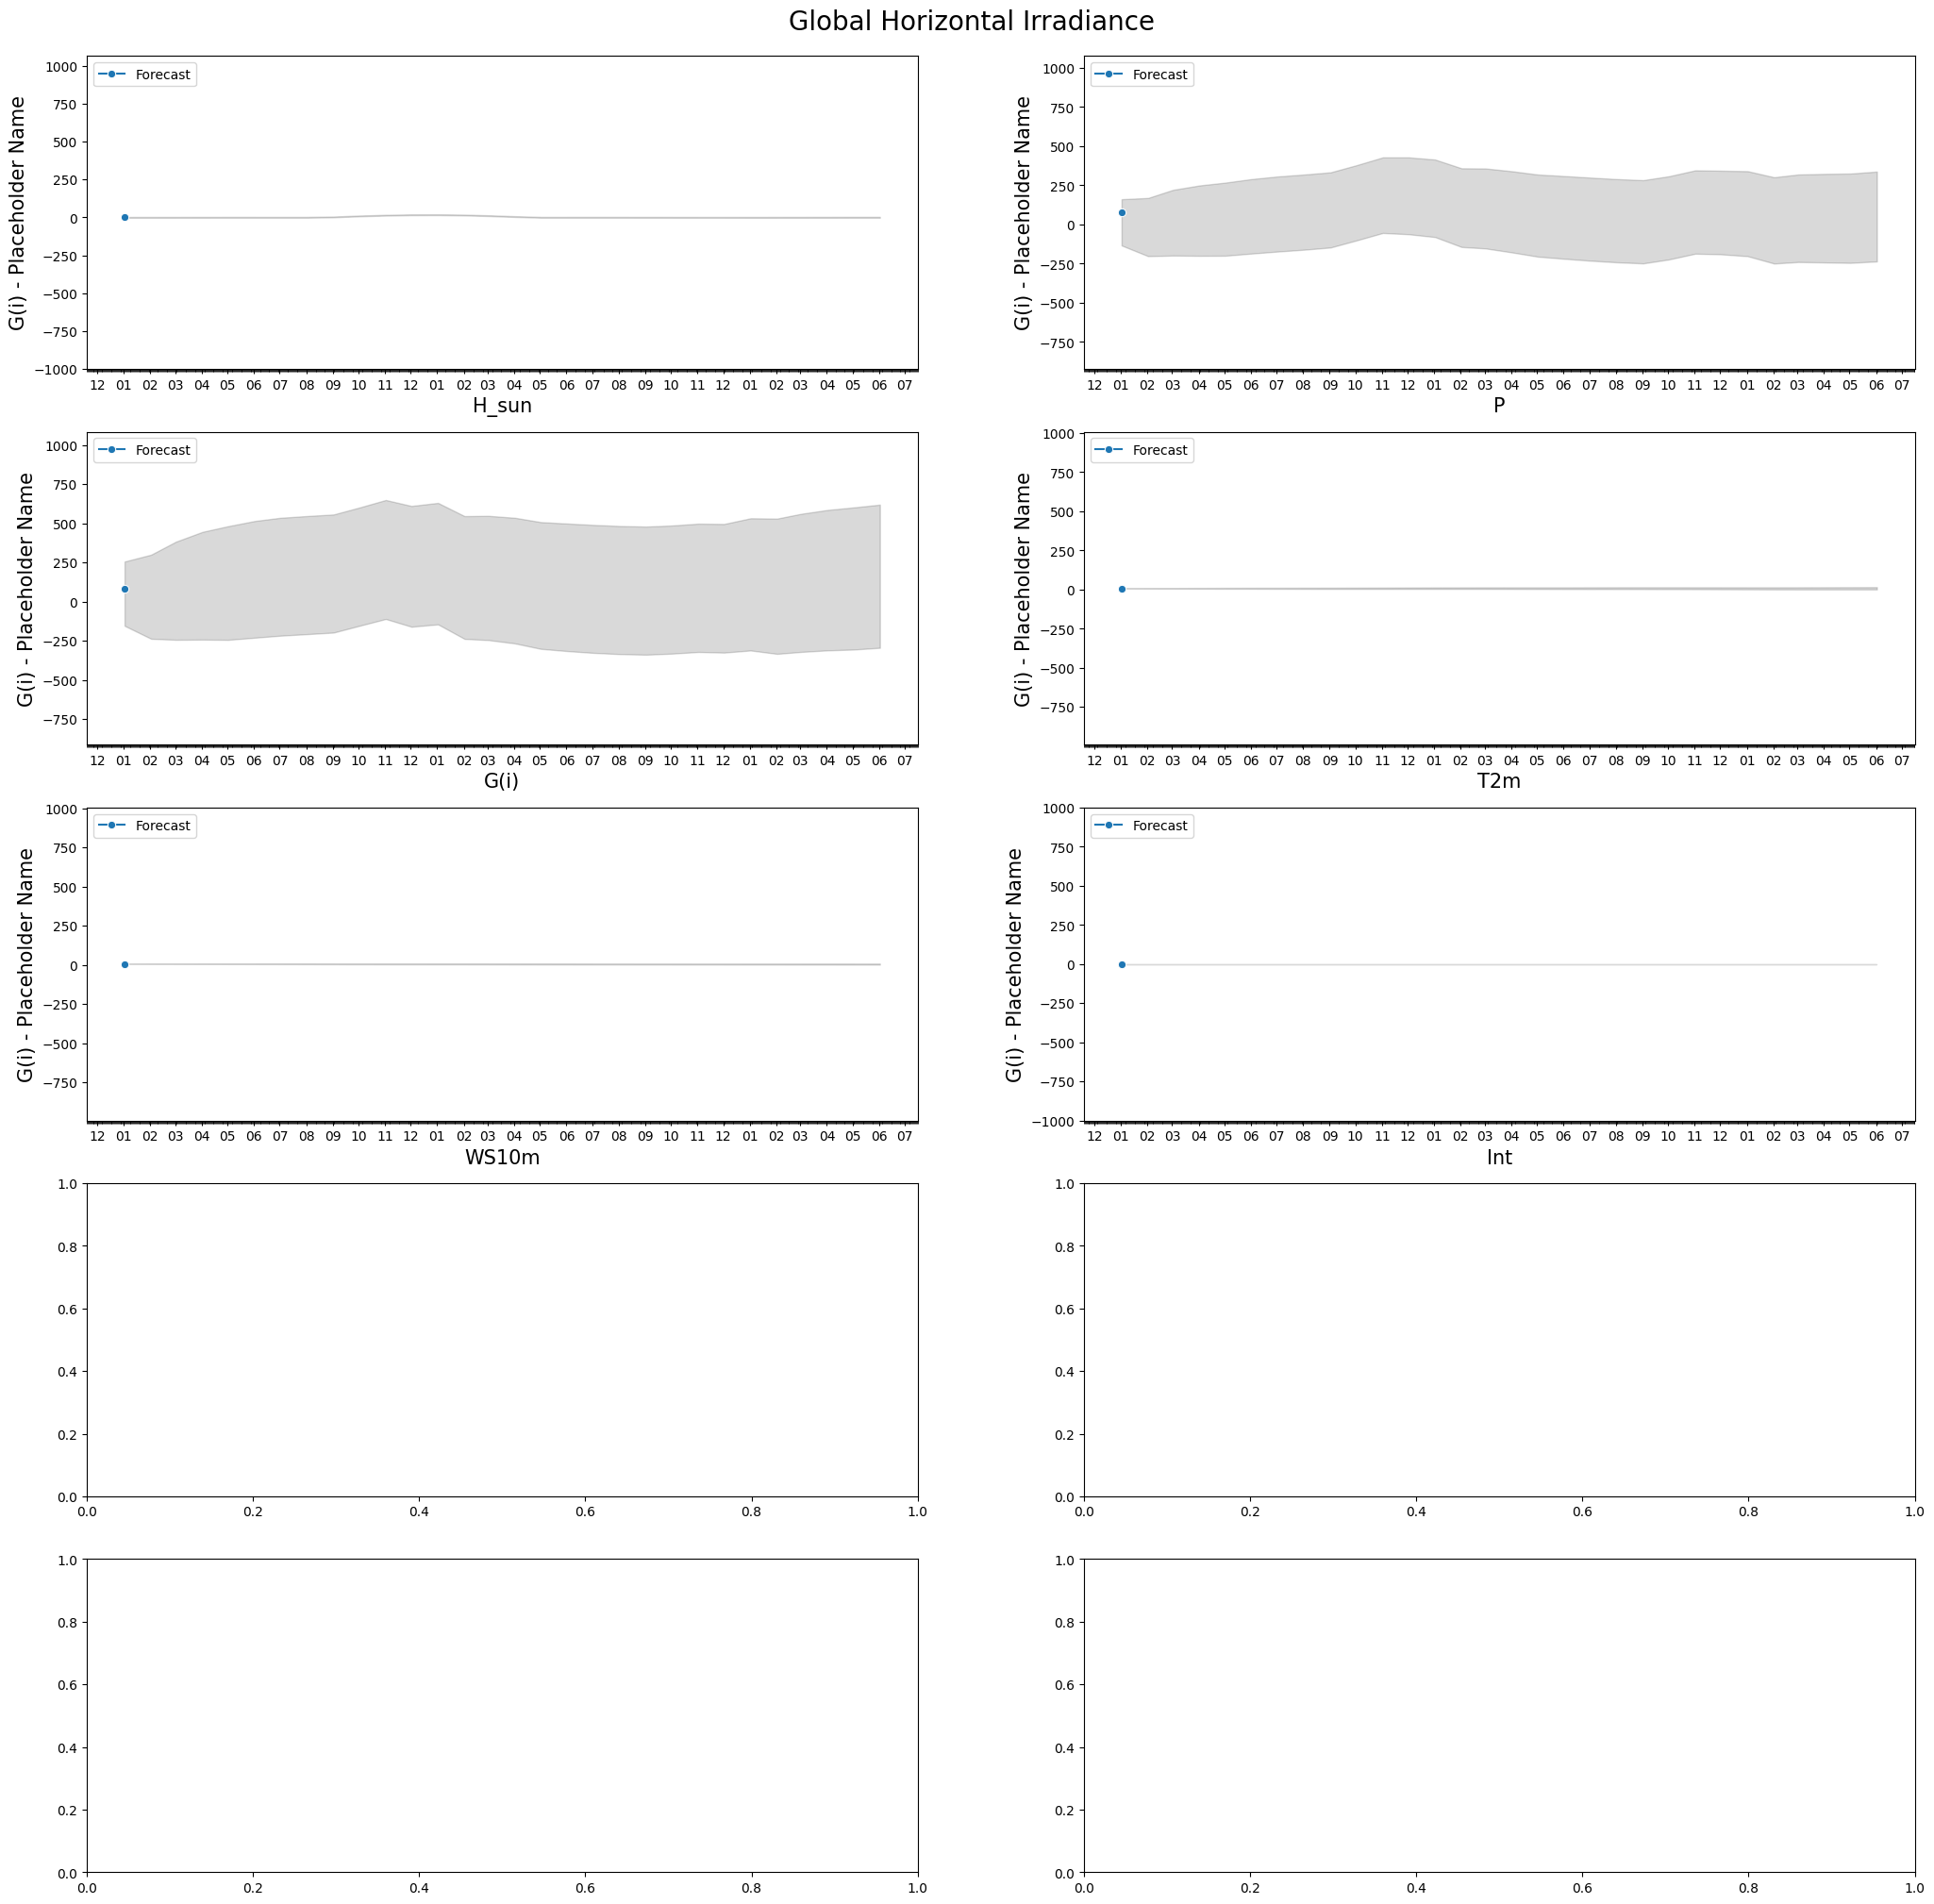

In [36]:
get_plot_fc(df_act_fc, 
            df_lower, 
            df_upper, 
            df_fitted,
            nrow = 5, ncol = 2, 
            figsize_x = 25, figsize_y = 25,
            category_field_values = df_act_fc.drop(['day', 'desc'], axis = 1).columns, 
            title = 'Global Horizontal Irradiance',
            ylabel = 'G(i) - Placeholder Name')

## towardsdatascience.com

In [10]:
# Calculate the split index
split_index = int(len(df_Compiegne) * 0.5)

# Split the DataFrame
df_Compiegne_2022 = df_Compiegne[:split_index]
df_Compiegne_2023 = df_Compiegne[split_index:]

# Display the sizes of the splits
print(f"Training set size: {len(df_Compiegne_2022)}")
print(f"Testing set size: {len(df_Compiegne_2023)}")

df_Compiegne_2023_Hsun = df_Compiegne_2023.iloc[:, [2]]

print(df_Compiegne_2023_Hsun.head())

df_Compiegne_2022_Hsun = df_Compiegne_2022.iloc[:, [2]]

print(df_Compiegne_2022_Hsun.head())

Training set size: 8760
Testing set size: 8760
                     H_sun
time                      
2023-01-01 00:10:00    0.0
2023-01-01 01:10:00    0.0
2023-01-01 02:10:00    0.0
2023-01-01 03:10:00    0.0
2023-01-01 04:10:00    0.0
                     H_sun
time                      
2022-01-01 00:10:00    0.0
2022-01-01 01:10:00    0.0
2022-01-01 02:10:00    0.0
2022-01-01 03:10:00    0.0
2022-01-01 04:10:00    0.0


<Axes: xlabel='time'>

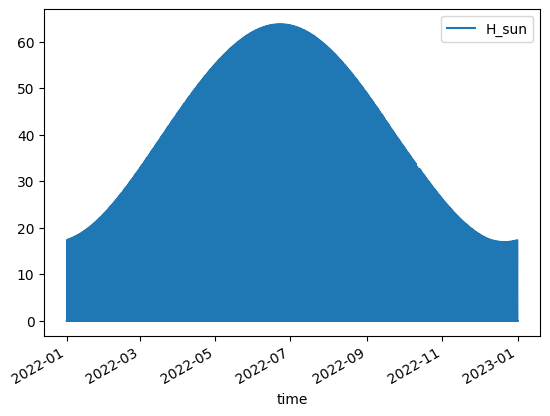

In [11]:
df_Compiegne_2022_Hsun.plot()

In [12]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df_Compiegne_2022_Hsun)

(0.2685079860897174, True)

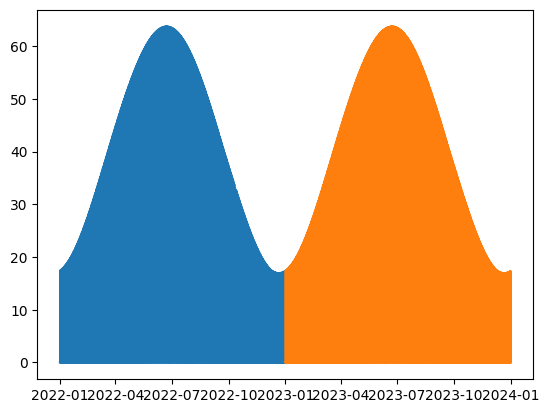

In [13]:
plt.plot(df_Compiegne_2022_Hsun)
plt.plot(df_Compiegne_2023_Hsun)

In [15]:
df_Compiegne_2022_Hsun = df_Compiegne_2022_Hsun.astype('float32')

In [18]:
arima_model = pm.auto_arima(df_Compiegne_2022_Hsun, start_p = 0, d = 0, start_q = 0,
                            max_p = 3, max_d = 5, max_q = 3, start_P = 0,
                            D = 1, start_Q = 0, max_P = 3, max_D = 3, max_Q = 3, m = 12,
                            seasonal = True, error_action = 'warn', trace = True,
                            suppress_warnings = True, stepwise = True, random_state = 20, n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=84971.890, Time=0.59 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=22.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=25.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=84969.890, Time=0.42 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=11.64 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=10.70 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=33025.717, Time=22.52 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=32170.142, Time=48.82 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=34.19 sec
 ARIMA(0,0,0)(3,1,1)[12] intercept   : AIC=31502.248, Time=101.58 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=inf, Time=89.72 sec
 ARIMA(0,0,0)(3,1,2)[12] intercept   : AIC=30790.678, Time=105.99 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=30809.547, Time=49.34 sec
 ARIMA(0,0,0)(3,1,3)[12] intercept   : AIC=30791.453, Time=169.29 sec
 ARIMA(0,0,0)(2,1,3)[12] i

In [19]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                 8760
Model:             SARIMAX(3, 0, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood              -14952.594
Date:                                    Wed, 29 Jan 2025   AIC                          29925.188
Time:                                            17:07:24   BIC                          29995.954
Sample:                                        01-01-2022   HQIC                         29949.302
                                             - 12-31-2022                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.997e-05      0.000     -0.378      0.705      -0.000       0.000
ar.L1          1.1962      0.005    238.937      0.000       1.186       1.206
ar.L2         -0.1573      0.004    -39.820      0.000      -0.165      -0.150
ar.L3         -0.0459      0.004    -11.548      0.000      -0.054      -0.038
ma.L1         -0.9758      0.005   -206.996      0.000      -0.985      -0.967
ar.S.L12      -0.9997      0.000  -6183.540      0.000      -1.000      -0.999
ma.S.L12      -0.0201      0.012     -1.703      0.089      -0.043       0.003
ma.S.L24      -0.6930      0.002   -438.614      0.000      -0.696      -0.690
ma.S.L36      -0.0461      0.009     -5.404      0.000      -0.063      -0.029
sigma2         1.7189      0.002    692.457      0.000       1.714       1.724
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):         242511550.19
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                           -20.50
Prob(H) (two-sided):                  0.00   Kurtosis:                       817.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 20), index = df_Compiegne_2023_Hsun.index)
prediction.columns = ['predicted']
prediction

,predicted
time,
2023-01-01 00:10:00,-0.005951
2023-01-01 01:10:00,-0.018878
2023-01-01 02:10:00,-0.032138
2023-01-01 03:10:00,-0.044797
2023-01-01 04:10:00,0.007052
...,...
2023-12-31 19:10:00,NaN
2023-12-31 20:10:00,NaN
2023-12-31 21:10:00,NaN


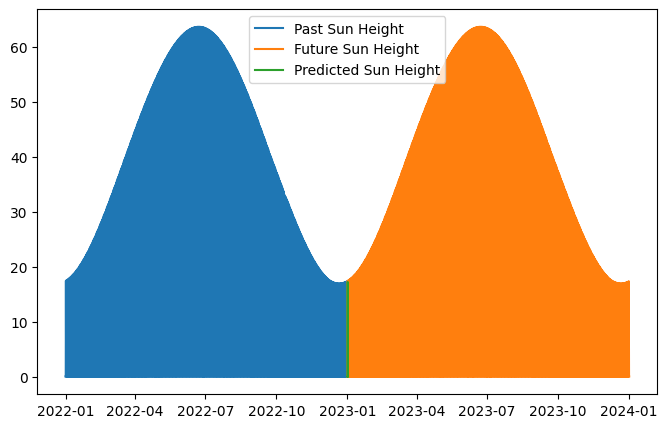

In [22]:
plt.figure(figsize = (8,5))
plt.plot(df_Compiegne_2022_Hsun, label = "Past Sun Height")
plt.plot(df_Compiegne_2023_Hsun, label = "Future Sun Height")
plt.plot(prediction, label = "Predicted Sun Height")
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import r2_score
df_Compiegne_2023_Hsun['predicted'] = prediction
r2_score(df_Compiegne_2023_Hsun['H_sun'], df_Compiegne_2023_Hsun['predicted'])

C:\Users\ugurhan\AppData\Local\Temp\ipykernel_13456\3086281215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Compiegne_2023_Hsun['predicted'] = prediction


ValueError: Input contains NaN.